In [1]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#modeling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn import model_selection as ms
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults, AR
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#stationarity assumption
from statsmodels.tsa.stattools import adfuller

#normal assumption
from scipy import stats

#trend analysis
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

#deep learning for time series modeling
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.preprocessing.sequence import TimeseriesGenerator

#prophet forecasting
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [10]:
new_df = pd.read_csv('injection_forecast_without_outliers.csv', index_col = 'date')

# Rolling Window Regression
- __I am going to create rolling window features and use them in a linear regression model__

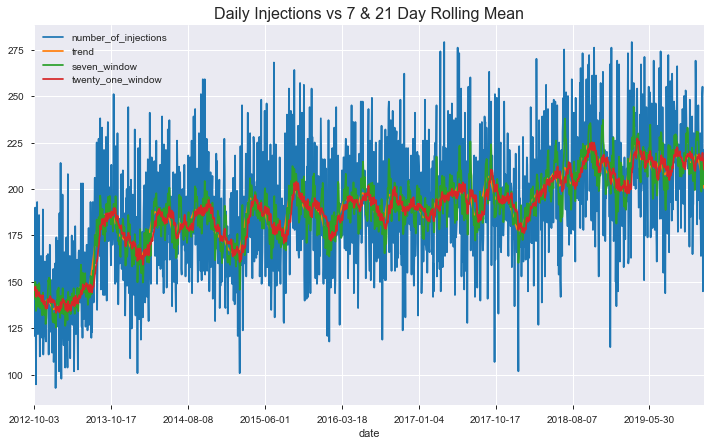

In [11]:
#create 7-day rolling window mean feature
new_df['seven_window'] = new_df['number_of_injections'].rolling(window = 7).mean()

#create 21-day rolling window feature
new_df['twenty_one_window'] = new_df['number_of_injections'].rolling(window = 21).mean()

#droppping na data since rolling windows introduce NaNs
new_df.dropna(inplace = True)

#now plot data against a rolling mean with a window size of 
new_df.plot(legend = True, figsize = (12, 7))
plt.title('Daily Injections vs 7 & 21 Day Rolling Mean', fontsize = 16);

In [12]:
new_df.head()

,number_of_injections,trend,seven_window,twenty_one_window
date,,,,
2012-10-03,121,142.69,141.00,146.43
2012-10-04,135,142.41,142.71,145.62
2012-10-05,190,142.15,150.14,147.57
2012-10-08,145,141.88,149.00,147.33
2012-10-09,95,141.63,134.43,142.29


In [13]:
#gives all scoring metrics from sklearn
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

## Model Evaluation
- __I am going to fit the model to the data and then measure its accuracy using K-Fold Cross Validation__
- __K-Fold Cross Validation trains the data on a specified number of "folds" of the data and evaluates it on the left out data for each fold__
    - Essentially, this means that we can fit the model to the entire data set and have it tested on several different unique test sets, with allows me to see how the model performs on several different windows of the data, thus increasing the generalizability of the results
    - Cross validation scores are usually more trustworthy than simple train-test split scores, especially on smaller data sets

In [14]:
#instantiate the model
model = LinearRegression()

#specify features and labels
features = new_df.drop('number_of_injections', axis = 1)
labels = new_df['number_of_injections']

#fit the model to the data
model.fit(features, labels)

#create cv_estimate of the model for 10 folds
cv_estimate = ms.cross_val_score(model, features, labels, cv = 10, scoring = 'neg_mean_squared_error')
print('Mean RMSE = %4.3f' % np.mean(np.sqrt(-cv_estimate)))
print('SDT of RMSE       = %4.3f' % np.std(np.sqrt(-cv_estimate)))
print('RMSE by cv fold')
for i, x in enumerate(cv_estimate):
    print('Number of Injections Off With Linear Regression Fold %2d    %4.3f' % (i+1, np.sqrt(-x)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Mean RMSE = 24.821
SDT of RMSE       = 1.748
RMSE by cv fold
Number of Injections Off With Linear Regression Fold  1    21.787
Number of Injections Off With Linear Regression Fold  2    24.298
Number of Injections Off With Linear Regression Fold  3    22.730
Number of Injections Off With Linear Regression Fold  4    25.302
Number of Injections Off With Linear Regression Fold  5    24.486
Number of Injections Off With Linear Regression Fold  6    25.388
Number of Injections Off With Linear Regression Fold  7    28.652
Number of Injections Off With Linear Regression Fold  8    24.675
Number of Injections Off With Linear Regression Fold  9    25.981
Number of Injections Off With Linear Regression Fold 10    24.915


## What About LightGBM Regression
- __Worth giving an ensemble method a try to see if its any better right out of the box__

In [16]:
#instantiate the model
model = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=400)

#specify features and labels
features = new_df.drop('number_of_injections', axis = 1)
labels = new_df['number_of_injections']

#fit the model to the data
model.fit(features, labels)

#create cv_estimate of the model for 10 folds
cv_estimate = ms.cross_val_score(model, features, labels, cv = 10, scoring = 'neg_mean_squared_error')
print('Mean RMSE = %4.3f' % np.mean(np.sqrt(-cv_estimate)))
print('SDT of RMSE       = %4.3f' % np.std(np.sqrt(-cv_estimate)))
print('RMSE by cv fold')
for i, x in enumerate(cv_estimate):
    print('Number of Injections Off With LightGBM Fold %2d    %4.3f' % (i+1, np.sqrt(-x)))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=400, n_jobs=-1, num_leaves=5, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Mean RMSE = 25.661
SDT of RMSE       = 1.579
RMSE by cv fold
Number of Injections Off With LightGBM Fold  1    25.282
Number of Injections Off With LightGBM Fold  2    24.585
Number of Injections Off With LightGBM Fold  3    23.495
Number of Injections Off With LightGBM Fold  4    26.264
Number of Injections Off With LightGBM Fold  5    24.442
Number of Injections Off With LightGBM Fold  6    25.794
Number of Injections Off With LightGBM Fold  7    29.255
Number of Injections Off With LightGBM Fold  8    24.829
Number of Injections Off With LightGBM Fold  9    27.467
Number of Injections Off With LightGBM Fold 10    25.198
